## Step 1: Import Required Libraries

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import speech_recognition as sr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')


## Step 2: Define Feature Extraction for Audio

In [2]:
def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)

    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_values = pitches[magnitudes > np.median(magnitudes)]
    avg_pitch = np.mean(pitch_values) if len(pitch_values) > 0 else 0
    pitch_var = np.var(pitch_values) if len(pitch_values) > 0 else 0

    intervals = librosa.effects.split(y, top_db=25)
    pause_count = len(intervals) - 1

    return {
        "duration": duration,
        "avg_pitch": avg_pitch,
        "pitch_var": pitch_var,
        "pause_count": pause_count
    }


In [3]:
extract_audio_features("common_voice_en_40865225.wav")

{'duration': 3.42,
 'avg_pitch': 1690.082,
 'pitch_var': 1243177.2,
 'pause_count': 4}

## Step 3: Transcribe Audio + Extract Text Features

In [4]:
def transcribe_audio(file_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(file_path) as source:
        audio = recognizer.record(source)
        try:
            text = recognizer.recognize_google(audio)
        except sr.UnknownValueError:
            text = ""
    return text

def extract_text_features(text):
    words = text.split()
    word_count = len(words)
    hesitation_markers = ["um", "uh", "erm"]
    hesitations = sum([text.lower().count(h) for h in hesitation_markers])
    avg_word_length = np.mean([len(w) for w in words]) if words else 0
    return {
        "word_count": word_count,
        "hesitations": hesitations,
        "avg_word_length": avg_word_length
    }


In [5]:
text = transcribe_audio("common_voice_en_40865225.wav")
print("Transcript:", text)
extract_text_features(text)


Transcript: in a pamphlet what is to be done


{'word_count': 8, 'hesitations': 0, 'avg_word_length': 3.125}

## Step 4: Combine All Features into One Row

In [6]:
audio_feats = extract_audio_features("common_voice_en_40865225.wav")
transcript = transcribe_audio("common_voice_en_40865225.wav")
text_feats = extract_text_features(transcript)

combined_features = {**audio_feats, **text_feats, "filename": "common_voice_en_40865225.wav"}
df = pd.DataFrame([combined_features])
df.set_index("filename", inplace=True)

In [7]:
df

,duration,avg_pitch,pitch_var,pause_count,word_count,hesitations,avg_word_length
filename,,,,,,,
common_voice_en_40865225.wav,3.42,1690.082031,1243177.25,4,8,0,3.125


In [9]:
audio_folder = r"C:\Users\Admin\Desktop\Voice-Based-Cognitive-Decline-Detection-main\Voice-Based-Cognitive-Decline-Detection-main\fake voice samples\audio_samples"
features = []

for filename in os.listdir(audio_folder):
    if filename.endswith(".wav"):
        path = os.path.join(audio_folder, filename)
        print(f"Processing: {filename}")
        audio_feats = extract_audio_features(path)
        text = transcribe_audio(path)
        text_feats = extract_text_features(text)
        combined = {**audio_feats, **text_feats, "filename": filename}
        features.append(combined)

df = pd.DataFrame(features)
df.set_index("filename", inplace=True)
df.fillna(0, inplace=True)
df


Processing: common_voice_en_40865225.wav
Processing: common_voice_en_40865481.wav
Processing: common_voice_en_40865482.wav
Processing: common_voice_en_40865483.wav
Processing: common_voice_en_40865484.wav


,duration,avg_pitch,pitch_var,pause_count,word_count,hesitations,avg_word_length
filename,,,,,,,
common_voice_en_40865225.wav,3.420,1690.082031,1243177.250,4,8,0,3.125000
common_voice_en_40865481.wav,4.608,1340.500977,996770.125,10,9,0,4.777778
common_voice_en_40865482.wav,4.284,1365.894897,1104203.750,4,10,0,5.400000
common_voice_en_40865483.wav,5.220,1566.147705,1114854.250,7,13,0,4.615385
common_voice_en_40865484.wav,4.788,1493.921753,1119288.000,3,1,0,4.000000


## Step 5: Clustering & Dimensionality Reduction

In [10]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled)

kmeans = KMeans(n_clusters=2, random_state=42)
df["cluster"] = kmeans.fit_predict(scaled)

In [11]:
df

,duration,avg_pitch,pitch_var,pause_count,word_count,hesitations,avg_word_length,cluster
filename,,,,,,,,
common_voice_en_40865225.wav,3.420,1690.082031,1243177.250,4,8,0,3.125000,1
common_voice_en_40865481.wav,4.608,1340.500977,996770.125,10,9,0,4.777778,0
common_voice_en_40865482.wav,4.284,1365.894897,1104203.750,4,10,0,5.400000,0
common_voice_en_40865483.wav,5.220,1566.147705,1114854.250,7,13,0,4.615385,0
common_voice_en_40865484.wav,4.788,1493.921753,1119288.000,3,1,0,4.000000,1


## Step 6: Visualize Clusters

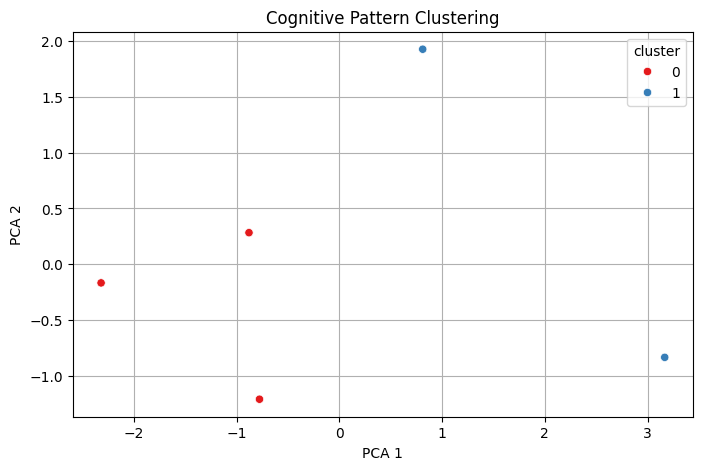

In [12]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster"], palette='Set1')
plt.title("Cognitive Pattern Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


## Step 7: Save Results

In [13]:
df.to_csv("bulk_voice_features.csv")
print("Results saved as 'bulk_voice_features.csv'")

Results saved as 'bulk_voice_features.csv'
